In [75]:
import numpy as np
import matplotlib.pyplot as plt
# import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Block, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

from scipy.interpolate import interp1d

import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from optimization_pyomo import ODEOptimizationModel

In [76]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = 0, 10
spacing_type = "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

In [57]:
# print(ODEOptimizationModel.__doc__)

In [73]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import jax
import jax.numpy as jnp

class ODEOptimizationModel:
    """
    Constructs and solves an optimization model using neural networks to fit observed data points to an ODE system with collocation constraints.

    This function sets up a neural network within a Pyomo optimization framework to learn dynamics from observed data points, 
    minimizing the difference between observed states and predicted states by adjusting the neural network's weights and biases 
    subject to ODE constraints defined via a collocation matrix.

    Parameters:
    y_observed (np.ndarray): An array of observed data points with shape (N, 2), where N is the number of time points and 2 corresponds to the state variables u and v.
    t (np.ndarray): An array of time points corresponding to the observations in y_observed.
    first_derivative_matrix (np.ndarray): A matrix representing the first derivative constraints imposed by a collocation method on the ODE solution.
    penalty_lambda (float, optional): A regularization parameter used to scale the penalty terms in the objective function. Default is 100.
    max_iter (int, optional): The maximum number of iterations for the solver to run. Default is 500.
    act_func (str, optional): The activation function used in the neural network. Supported options are 'tanh', 'sigmoid', and 'softplus'. Default is 'tanh'.
    w_init_method (str, optional): Method to initialize weights; supported methods are 'random', 'xavier', and 'he'. Default is 'random'.

    Returns:
    ConcreteModel: A Pyomo ConcreteModel instance after solving. The model contains the solution, including the optimized values of state variables u and v, and the learned neural network parameters.

    Raises:
    ValueError: If an unsupported activation function or weight initialization method is specified.
    """
    def __init__(self, y_observed, t, first_derivative_matrix, layer_sizes, penalty_lambda=100, max_iter=500, act_func="tanh", w_init_method="random"):
        self.y_observed = y_observed
        self.t = t
        self.first_derivative_matrix = first_derivative_matrix
        self.penalty_lambda = penalty_lambda
        self.max_iter = max_iter
        self.act_func = act_func
        self.w_init_method = w_init_method
        self.model = ConcreteModel()
        self.layer_sizes = layer_sizes
        self.model.vars = {}

    def initialize_weights(self, shape):
        if self.w_init_method == 'random':
            return np.random.randn(*shape) * 0.1
        elif self.w_init_method == 'xavier':
            return np.random.randn(*shape) * np.sqrt(2 / (shape[0] + shape[1]))
        elif self.w_init_method == 'he':
            return np.random.randn(*shape) * np.sqrt(2 / shape[0])
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")
        
    def initialize_biases(self, size):
        return np.random.randn(size) * 0.1

#-----------------------------------------------------------------------------------------#
#---------------------------------------MODEL SET UP--------------------------------------#

#----------------------------------------NN_OUTPUT-----------------------------------------#

    def nn_output(self, t, u, v, nn_block):
        inputs = [t, u, v]
        for i in range(len(self.layer_sizes) - 1):
            new_inputs = []
            W = nn_block.W[i]
            b = nn_block.b[i]
            for j in range(self.layer_sizes[i + 1]):
                neuron_input = sum(W[j, k] * inputs[k] for k in range(self.layer_sizes[i])) + b[j]
                if i < len(self.layer_sizes) - 2:
                    if self.act_func == "tanh":
                        neuron_input = pyo.tanh(neuron_input)
                    elif self.act_func == "sigmoid":
                        neuron_input = 1 / (1 + pyo.exp(-neuron_input))
                    elif self.act_func == "softplus":
                        neuron_input = pyo.log(1 + pyo.exp(neuron_input))
                new_inputs.append(neuron_input)
            inputs = new_inputs
        return inputs

    def build_model(self):
        N = len(self.t)
        model = self.model
        model.t_idx = RangeSet(0, N - 1)

        model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
        model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)

        model.nn_block = Block()

        # Define weights and biases within the Block
        model.nn_block.W = {}
        model.nn_block.b = {}
        for i in range(len(self.layer_sizes) - 1):
            layer_input = self.layer_sizes[i]
            layer_output = self.layer_sizes[i + 1]

            model.nn_block.W[i] = Var(range(layer_output), range(layer_input), initialize=0.1)
            model.nn_block.b[i] = Var(range(layer_output), initialize=0.1)
            
        penalty_terms = []
        model.ode = ConstraintList()
        for i in range(1, N):
            du_dt = sum(self.first_derivative_matrix[i, j] * model.u[j] for j in range(N))
            dv_dt = sum(self.first_derivative_matrix[i, j] * model.v[j] for j in range(N))

            nn_u, nn_v = self.nn_output(self.t[i], model.u[i], model.v[i], model)

            collocation_constraint_u = nn_u - du_dt
            collocation_constraint_v = nn_v - dv_dt

            model.ode.add(collocation_constraint_u == 0)
            model.ode.add(collocation_constraint_v == 0)

            penalty_terms.append((collocation_constraint_u)**2 + (collocation_constraint_v)**2)

        def _objective(m):
            data_fit = sum((m.u[i] - self.y_observed[i, 0])**2 + (m.v[i] - self.y_observed[i, 1])**2 for i in m.t_idx)
            penalty = self.penalty_lambda * sum(penalty_terms)
            return penalty + data_fit

        model.obj = Objective(rule=_objective, sense=pyo.minimize)
        # self.model = model

#----------------------------------------SOLVE-------------------------------------#
    def solve_model(self):
        solver = pyo.SolverFactory('ipopt')
        solver.options['max_iter'] = self.max_iter
        solver.solve(self.model)

#----------------------------------EXTRACT SOLUTION--------------------------------#
    def extract_solution(self):
        u = np.array([pyo.value(self.model.u[i]) for i in self.model.t_idx])
        v = np.array([pyo.value(self.model.v[i]) for i in self.model.t_idx])
        return u, v
    
#------------------------------------extract weights---------------------------------#
    def extract_weights(self):
        weights = {}
        for i in range(len(self.layer_sizes) - 1):
            W = np.array([[pyo.value(getattr(self.model, f'W_{i}')[j, k]) for k in range(self.layer_sizes[i])] for j in range(self.layer_sizes[i + 1])])
            b = np.array([pyo.value(getattr(self.model, f'b_{i}')[j]) for j in range(self.layer_sizes[i + 1])])
            weights[f'layer_{i}'] = (W, b)
        return weights

#----------------------------------------PREDICT-------------------------------------#
    def predict(self, t, u, v):
        weights = self.extract_weights()
        inputs = jnp.array([t, u, v])

        for i in range(len(self.layer_sizes) - 1):
            W, b = weights[f'layer_{i}']
            inputs = jnp.dot(W, inputs) + b
            if i < len(self.layer_sizes) - 2:
                if self.act_func == "tanh":
                    inputs = jax.nn.tanh(inputs)
                elif self.act_func == "sigmoid":
                    inputs = jax.nn.sigmoid(inputs)
                elif self.act_func == "softplus":
                    inputs = jax.nn.softplus(inputs)
        return inputs

#----------------------------------------ERROR-------------------------------------#
    def mae(self, y_true, u, v):
        combined = np.vstack((u, v)).T
        mae_result = np.mean(np.abs(y_true - combined))
        return mae_result


if __name__ == "__main__":
    """ode_model = ODEOptimizationModel(y_observed, t, first_derivative_matrix)
    ode_model.build_model()
    ode_model.solve_model()
    u, v = ode_model.extract_solution()"""
    


In [74]:
ode_model = ODEOptimizationModel(y_noisy, t, D, [3, 10, 2], penalty_lambda = 1000, max_iter = 10000)
ode_model.build_model()
ode_model.solve_model()

ValueError: Error retrieving component IndexedVar[0]: The component has not been constructed.

In [69]:
u_model, v_model = ode_model.extract_solution()
ode_model.extract_weights()

{'layer_0': (array([[0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1]]),
  array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])),
 'layer_1': (array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]),
  array([0.1, 0.1]))}

In [70]:
u, v = ode_model.extract_solution()

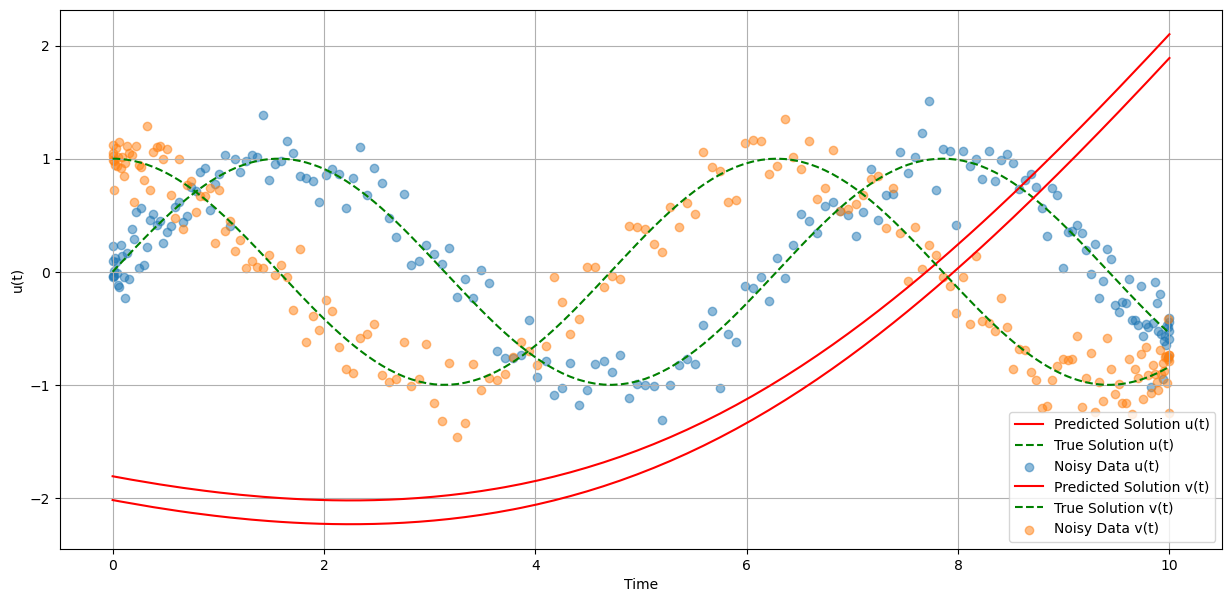

In [71]:
plt.figure(figsize=(15, 7))
plt.plot(t, u, 'r', label='Predicted Solution u(t)')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, v, 'r', label='Predicted Solution v(t)')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
# plt.title(f'Harmonic Oscillator ODE using IPOPT and Pyomo; MAE: {MAE:.3f}')
plt.grid(True)
plt.show()

In [36]:
def predict(t, u, v):
    inputs = jnp.array([t, u, v])
    hidden_layer = jax.nn.tanh(jnp.dot(W1, inputs) + b1)
    output_layer = jnp.dot(W2, hidden_layer) + b2
    return output_layer  # returns [du/dt, dv/dt]

def system_dynamics(y, t, W1, b1, W2, b2):
    u, v = y
    du_dt, dv_dt = predict(t, u, v, W1, b1, W2, b2)
    return jnp.array([du_dt, dv_dt])

In [43]:
initial_conditions = jnp.array([0.0, 1.0]) 
solution = odeint(system_dynamics, initial_conditions, t, W1_learned, b1_learned, W2_learned, b2_learned)
u_odeint, v_odeint = solution[:, 0], solution[:, 1]

In [44]:
print(ode_model.mae(y, u_model, v_model))
print(ode_model.mae(y, u_odeint, v_odeint))

0.02575197716203874
0.03720982207147935


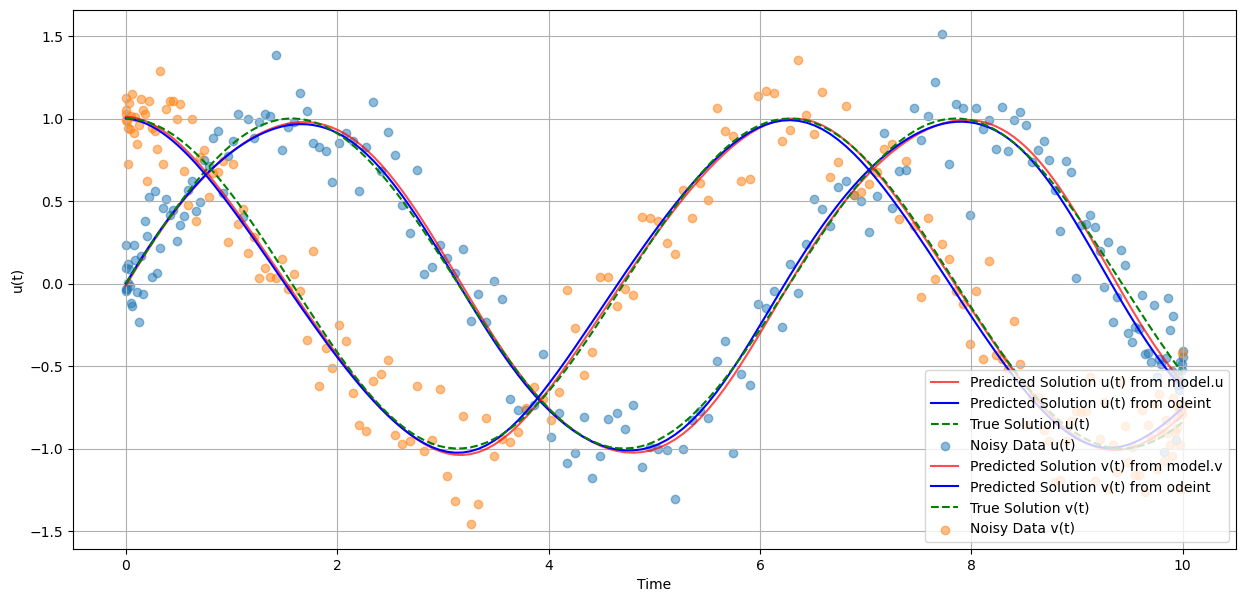

In [45]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t, solution.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t, solution.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
# plt.title(f'Harmonic Oscillator ODE using IPOPT and Pyomo; MAE: {MAE:.3f}')
plt.grid(True)
plt.show()

`N of points`